In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from concurrent.futures import ThreadPoolExecutor
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE

def exact_solver(problem, converter):
    print(problem)
    print(converter)
    #print("I AM HERE11")
    solver = NumPyMinimumEigensolverFactory()
    #print("I AM HERE12")
    calc = GroundStateEigensolver(converter, solver)
    #print("I AM HERE13")
    #result = calc.solve(problem)
    #print("I AM HERE14")
    return 0

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    #hamiltonian = electronic_energy.second_q_ops()["ElectronicEnergy"]
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):
    
    
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator')
        #backend.set_options(max_job_size=1,executor=euler_client)
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'qasm':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
     
    #result = exact_solver(problem,converter)
    
    #print(num_orb)
    #print(num_part)
    num_orb = 4
    init_state = HartreeFock(num_orb, num_part, converter)
    
    #print(init_state)
    #print(op)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 

    vqe_result = vqe.compute_minimum_eigenvalue(op)

    min_eng = vqe_result.eigenvalue

    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    #euler_client.close()
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
        
    return E

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])

    rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
    qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
    op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates):
    
    coordinate_list = []
    for i in range(len(coordinates)):
        coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:]])
    
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))

    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es = pool.starmap(task1, triples)

    for i in range(len(Es)):
        exp_dict[triples[i][0]]=Es[i]

    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
    finish = time.time()
    print("Took " + str(finish - start) + " seconds to find ground state")
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    start = time.time()
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces, vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates)
    
    #print(force_ops)
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    parallel_expectations(exp_dict,pauli_op_set,q_instance,psi_0)

    
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract 
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 100.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 16448)
    
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 0/500 [00:00<?, ?it/s]/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


ground state energy:  (-3.2094852397386386+0j)


Progress:   0%|          | 1/500 [00:10<1:26:37, 10.42s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.46s
ground state energy:  (-3.199451919800782+0j)


Progress:   0%|          | 2/500 [00:19<1:21:33,  9.83s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.64s, Calculate Covariance - 0.49s
ground state energy:  (-3.1800601519217415+0j)


Progress:   1%|          | 3/500 [00:29<1:21:09,  9.80s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 0.79s
ground state energy:  (-3.152666942636751+0j)


Progress:   1%|          | 4/500 [00:39<1:22:17,  9.95s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.89s
ground state energy:  (-3.11865025581049+0j)


Progress:   1%|          | 5/500 [00:49<1:21:17,  9.85s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.79s
ground state energy:  (-3.079689069916316+0j)


Progress:   1%|          | 6/500 [00:59<1:22:28, 10.02s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 2.45s, Calculate Covariance - 0.79s
ground state energy:  (-3.0374211871003105+0j)


Progress:   1%|▏         | 7/500 [01:09<1:20:32,  9.80s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.86s
ground state energy:  (-2.993208108869425+0j)


Progress:   2%|▏         | 8/500 [01:19<1:21:17,  9.91s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 1.01s
ground state energy:  (-2.948393992587305+0j)


Progress:   2%|▏         | 9/500 [01:29<1:22:43, 10.11s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.59s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.86s
ground state energy:  (-2.904030371208951+0j)


Progress:   2%|▏         | 10/500 [01:39<1:22:04, 10.05s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.91s
ground state energy:  (-2.8609823295998353+0j)


Progress:   2%|▏         | 11/500 [01:49<1:20:12,  9.84s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.92s
ground state energy:  (-2.819922966407529+0j)


Progress:   2%|▏         | 12/500 [01:59<1:20:44,  9.93s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.94s
ground state energy:  (-2.781411489929687+0j)


Progress:   3%|▎         | 13/500 [02:09<1:20:12,  9.88s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.86s
ground state energy:  (-2.7457928411387065+0j)


Progress:   3%|▎         | 14/500 [02:19<1:20:25,  9.93s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.1s
ground state energy:  (-2.7132753486596286+0j)


Progress:   3%|▎         | 15/500 [02:28<1:19:43,  9.86s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.06s
ground state energy:  (-2.6840112782019876+0j)


Progress:   3%|▎         | 16/500 [02:38<1:18:53,  9.78s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.83s
ground state energy:  (-2.658091832769254+0j)


Progress:   3%|▎         | 17/500 [02:48<1:18:22,  9.74s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.73s
ground state energy:  (-2.6355544281896557+0j)


Progress:   4%|▎         | 18/500 [02:57<1:18:47,  9.81s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.78s
ground state energy:  (-2.6163943918029715+0j)


Progress:   4%|▍         | 19/500 [03:07<1:18:02,  9.73s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.93s
ground state energy:  (-2.6005937220895716+0j)


Progress:   4%|▍         | 20/500 [03:17<1:18:47,  9.85s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.91s
ground state energy:  (-2.5881273852329825+0j)


Progress:   4%|▍         | 21/500 [03:27<1:19:10,  9.92s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.92s
ground state energy:  (-2.5789614185537753+0j)


Progress:   4%|▍         | 22/500 [03:37<1:19:01,  9.92s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 0.77s
ground state energy:  (-2.5730410862960524+0j)


Progress:   5%|▍         | 23/500 [03:47<1:19:16,  9.97s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.79s
ground state energy:  (-2.57033089943099+0j)


Progress:   5%|▍         | 24/500 [03:57<1:18:31,  9.90s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.76s
ground state energy:  (-2.570789244582553+0j)


Progress:   5%|▌         | 25/500 [04:07<1:18:50,  9.96s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.8s
ground state energy:  (-2.574366162088751+0j)


Progress:   5%|▌         | 26/500 [04:17<1:17:59,  9.87s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.84s
ground state energy:  (-2.5810395659634504+0j)


Progress:   5%|▌         | 27/500 [04:27<1:19:00, 10.02s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 3.0s, Calculate Covariance - 0.77s
ground state energy:  (-2.590768924241732+0j)


Progress:   6%|▌         | 28/500 [04:37<1:19:22, 10.09s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.78s
ground state energy:  (-2.6035059114415406+0j)


Progress:   6%|▌         | 29/500 [04:47<1:18:50, 10.04s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 1.06s
ground state energy:  (-2.6192013116175508+0j)


Progress:   6%|▌         | 30/500 [04:57<1:17:24,  9.88s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.89s
ground state energy:  (-2.637778420281291+0j)


Progress:   6%|▌         | 31/500 [05:07<1:17:19,  9.89s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.89s
ground state energy:  (-2.6591449084347167+0j)


Progress:   6%|▋         | 32/500 [05:16<1:16:28,  9.80s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 1.02s
ground state energy:  (-2.683181016382237+0j)


Progress:   7%|▋         | 33/500 [05:26<1:16:19,  9.81s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.93s
ground state energy:  (-2.7097703535336435+0j)


Progress:   7%|▋         | 34/500 [05:36<1:15:57,  9.78s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.77s
ground state energy:  (-2.7387929974861924+0j)


Progress:   7%|▋         | 35/500 [05:46<1:17:22,  9.98s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.24s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.09s
ground state energy:  (-2.7700095371219953+0j)


Progress:   7%|▋         | 36/500 [05:56<1:17:24, 10.01s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 1.0s
ground state energy:  (-2.803104017200384+0j)


Progress:   7%|▋         | 37/500 [06:07<1:17:34, 10.05s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.12s
ground state energy:  (-2.8376647973231446+0j)


Progress:   8%|▊         | 38/500 [06:16<1:16:36,  9.95s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 1.04s
ground state energy:  (-2.873268835530715+0j)


Progress:   8%|▊         | 39/500 [06:27<1:17:20, 10.07s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.99s
ground state energy:  (-2.909288393207773+0j)


Progress:   8%|▊         | 40/500 [06:36<1:15:49,  9.89s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.83s
ground state energy:  (-2.945121522236803+0j)


Progress:   8%|▊         | 41/500 [06:46<1:14:48,  9.78s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 1.0s
ground state energy:  (-2.97993525555985+0j)


Progress:   8%|▊         | 42/500 [06:55<1:13:52,  9.68s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.85s
ground state energy:  (-3.0128303571594914+0j)


Progress:   9%|▊         | 43/500 [07:06<1:15:48,  9.95s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 1.12s
ground state energy:  (-3.042907424515023+0j)


Progress:   9%|▉         | 44/500 [07:16<1:16:32, 10.07s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 1.06s
ground state energy:  (-3.069161191735701+0j)


Progress:   9%|▉         | 45/500 [07:26<1:16:24, 10.08s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 1.0s
ground state energy:  (-3.0906781665247958+0j)


Progress:   9%|▉         | 46/500 [07:36<1:15:47, 10.02s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.78s
ground state energy:  (-3.106703729507381+0j)


Progress:   9%|▉         | 47/500 [07:46<1:14:48,  9.91s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.78s
ground state energy:  (-3.1166285140732573+0j)


Progress:  10%|▉         | 48/500 [07:55<1:13:42,  9.78s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.79s
ground state energy:  (-3.1200100212027815+0j)


Progress:  10%|▉         | 49/500 [08:05<1:12:44,  9.68s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.78s
ground state energy:  (-3.116888875888368+0j)


Progress:  10%|█         | 50/500 [08:14<1:12:52,  9.72s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 1.04s
ground state energy:  (-3.1074804231151534+0j)


Progress:  10%|█         | 51/500 [08:26<1:17:46, 10.39s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 7.91s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 0.77s
ground state energy:  (-3.092279505868804+0j)


Progress:  10%|█         | 52/500 [08:35<1:14:41, 10.00s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.82s
ground state energy:  (-3.071973493303519+0j)


Progress:  11%|█         | 53/500 [08:44<1:12:20,  9.71s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.77s
ground state energy:  (-3.047484743380174+0j)


Progress:  11%|█         | 54/500 [08:54<1:11:05,  9.56s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.87s
ground state energy:  (-3.019699373871071+0j)


Progress:  11%|█         | 55/500 [09:04<1:12:29,  9.77s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 1.06s
ground state energy:  (-2.989595259278371+0j)


Progress:  11%|█         | 56/500 [09:13<1:11:52,  9.71s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.81s
ground state energy:  (-2.9582234594098806+0j)


Progress:  11%|█▏        | 57/500 [09:23<1:10:48,  9.59s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.84s
ground state energy:  (-2.926160798589846+0j)


Progress:  12%|█▏        | 58/500 [09:32<1:10:36,  9.59s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.8945597042123334+0j)


Progress:  12%|█▏        | 59/500 [09:42<1:10:40,  9.62s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.79s
ground state energy:  (-2.8636543388082227+0j)


Progress:  12%|█▏        | 60/500 [09:51<1:10:09,  9.57s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 1.03s
ground state energy:  (-2.8342204374382183+0j)


Progress:  12%|█▏        | 61/500 [10:01<1:10:35,  9.65s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.97s
ground state energy:  (-2.8065026518191893+0j)


Progress:  12%|█▏        | 62/500 [10:11<1:09:30,  9.52s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.78s
ground state energy:  (-2.780860109962802+0j)


Progress:  13%|█▎        | 63/500 [10:19<1:05:59,  9.06s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 4.16s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.74s
ground state energy:  (-2.7576545145545426+0j)


Progress:  13%|█▎        | 64/500 [10:28<1:07:22,  9.27s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.63s, Calculate Covariance - 0.85s
ground state energy:  (-2.7368950538682584+0j)


Progress:  13%|█▎        | 65/500 [10:40<1:12:44, 10.03s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 7.69s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.88s
ground state energy:  (-2.7186946290455607+0j)


Progress:  13%|█▎        | 66/500 [10:52<1:15:40, 10.46s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 6.72s, Calculate Pauli Expectation Values - 2.93s, Calculate Covariance - 0.85s
ground state energy:  (-2.703098429482751+0j)


Progress:  13%|█▎        | 67/500 [11:02<1:14:33, 10.33s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.8s, Calculate Covariance - 0.79s
ground state energy:  (-2.6901895247601866+0j)


Progress:  14%|█▎        | 68/500 [11:12<1:14:54, 10.40s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.79s, Calculate Covariance - 0.85s
ground state energy:  (-2.6800025714520035+0j)


Progress:  14%|█▍        | 69/500 [11:23<1:15:00, 10.44s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 2.71s, Calculate Covariance - 1.02s
ground state energy:  (-2.6725352014088726+0j)


Progress:  14%|█▍        | 70/500 [11:33<1:15:10, 10.49s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.9s
ground state energy:  (-2.6677409055547203+0j)


Progress:  14%|█▍        | 71/500 [11:46<1:19:16, 11.09s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 8.14s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 0.96s
ground state energy:  (-2.665607146304053+0j)


Progress:  14%|█▍        | 72/500 [11:57<1:18:46, 11.04s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.48s, Calculate Pauli Expectation Values - 2.67s, Calculate Covariance - 0.91s
ground state energy:  (-2.6661337317906457+0j)


Progress:  15%|█▍        | 73/500 [12:07<1:16:53, 10.80s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 1.11s
ground state energy:  (-2.6692605486041177+0j)


Progress:  15%|█▍        | 74/500 [12:18<1:16:10, 10.73s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 2.62s, Calculate Covariance - 0.89s
ground state energy:  (-2.6749484425266257+0j)


Progress:  15%|█▌        | 75/500 [12:31<1:21:42, 11.53s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 9.05s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.95s
ground state energy:  (-2.6831153399246253+0j)


Progress:  15%|█▌        | 76/500 [12:41<1:18:40, 11.13s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 1.0s
ground state energy:  (-2.693703649071874+0j)


Progress:  15%|█▌        | 77/500 [12:52<1:17:17, 10.96s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 3.19s, Calculate Covariance - 0.8s
ground state energy:  (-2.7065989401120114+0j)


Progress:  16%|█▌        | 78/500 [13:02<1:16:14, 10.84s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.84s
ground state energy:  (-2.7217325613177263+0j)


Progress:  16%|█▌        | 79/500 [13:12<1:12:49, 10.38s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.78s
ground state energy:  (-2.738967541042942+0j)


Progress:  16%|█▌        | 80/500 [13:21<1:11:11, 10.17s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.84s
ground state energy:  (-2.7581201979431564+0j)


Progress:  16%|█▌        | 81/500 [13:32<1:11:32, 10.24s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.84s
ground state energy:  (-2.7790079693591303+0j)


Progress:  16%|█▋        | 82/500 [13:42<1:10:33, 10.13s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.1s
ground state energy:  (-2.8013219149838875+0j)


Progress:  17%|█▋        | 83/500 [13:51<1:09:50, 10.05s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.84s
ground state energy:  (-2.824874392204836+0j)


Progress:  17%|█▋        | 84/500 [14:02<1:09:58, 10.09s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 2.17s, Calculate Covariance - 1.11s
ground state energy:  (-2.849345413678093+0j)


Progress:  17%|█▋        | 85/500 [14:12<1:10:53, 10.25s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.41s, Calculate Pauli Expectation Values - 2.52s, Calculate Covariance - 0.84s
ground state energy:  (-2.8743240441097564+0j)


Progress:  17%|█▋        | 86/500 [14:22<1:10:04, 10.16s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.85s
ground state energy:  (-2.8993560612502245+0j)


Progress:  17%|█▋        | 87/500 [14:32<1:08:31,  9.95s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.96s
ground state energy:  (-2.9239797915860786+0j)


Progress:  18%|█▊        | 88/500 [14:41<1:06:51,  9.74s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 2.39s, Calculate Covariance - 1.04s
ground state energy:  (-2.9476850407337154+0j)


Progress:  18%|█▊        | 89/500 [14:51<1:06:35,  9.72s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.98s
ground state energy:  (-2.969875347657364+0j)


Progress:  18%|█▊        | 90/500 [15:00<1:05:37,  9.60s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.8s
ground state energy:  (-2.990024000982502+0j)


Progress:  18%|█▊        | 91/500 [15:10<1:06:30,  9.76s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 2.62s, Calculate Covariance - 0.85s
ground state energy:  (-3.0075729895882795+0j)


Progress:  18%|█▊        | 92/500 [15:20<1:06:33,  9.79s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 2.73s, Calculate Covariance - 0.96s
ground state energy:  (-3.022092775880851+0j)


Progress:  19%|█▊        | 93/500 [15:29<1:05:23,  9.64s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.78s
ground state energy:  (-3.033149953244589+0j)


Progress:  19%|█▉        | 94/500 [15:39<1:06:16,  9.79s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.84s
ground state energy:  (-3.0403562555144727+0j)


Progress:  19%|█▉        | 95/500 [15:49<1:05:58,  9.77s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 2.78s, Calculate Covariance - 0.8s
ground state energy:  (-3.0435574339429357+0j)


Progress:  19%|█▉        | 96/500 [15:59<1:05:58,  9.80s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.78s
ground state energy:  (-3.042662153382649+0j)


Progress:  19%|█▉        | 97/500 [16:08<1:04:55,  9.67s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.81s
ground state energy:  (-3.037776104094886+0j)


Progress:  20%|█▉        | 98/500 [16:17<1:03:49,  9.53s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.77s
ground state energy:  (-3.0290784103037454+0j)


Progress:  20%|█▉        | 99/500 [16:27<1:04:12,  9.61s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.78s
ground state energy:  (-3.016982449842356+0j)


Progress:  20%|██        | 100/500 [16:37<1:03:42,  9.56s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.82s
ground state energy:  (-3.0019609326685863+0j)


Progress:  20%|██        | 101/500 [16:46<1:03:45,  9.59s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.78s
ground state energy:  (-2.9844877990150533+0j)


Progress:  20%|██        | 102/500 [16:56<1:03:36,  9.59s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.77s
ground state energy:  (-2.9652084468125266+0j)


Progress:  21%|██        | 103/500 [17:05<1:03:22,  9.58s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.13s, Calculate Covariance - 1.1s
ground state energy:  (-2.94455652342449+0j)


Progress:  21%|██        | 104/500 [17:15<1:03:07,  9.56s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 2.67s, Calculate Covariance - 0.77s
ground state energy:  (-2.9231234857626314+0j)


Progress:  21%|██        | 105/500 [17:24<1:02:41,  9.52s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.78s
ground state energy:  (-2.901374666621806+0j)


Progress:  21%|██        | 106/500 [17:34<1:02:54,  9.58s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.77s
ground state energy:  (-2.8800460207965357+0j)


Progress:  21%|██▏       | 107/500 [17:45<1:05:04,  9.94s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.73s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.96s
ground state energy:  (-2.859093612939333+0j)


Progress:  22%|██▏       | 108/500 [17:55<1:05:44, 10.06s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.78s
ground state energy:  (-2.839035688462126+0j)


Progress:  22%|██▏       | 109/500 [18:05<1:05:13, 10.01s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 1.0s
ground state energy:  (-2.8201338963172984+0j)


Progress:  22%|██▏       | 110/500 [18:15<1:05:19, 10.05s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 1.03s
ground state energy:  (-2.8026250429440625+0j)


Progress:  22%|██▏       | 111/500 [18:28<1:10:52, 10.93s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 8.7s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.84s
ground state energy:  (-2.787409920084454+0j)


Progress:  22%|██▏       | 112/500 [18:38<1:08:47, 10.64s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 2.61s, Calculate Covariance - 0.96s
ground state energy:  (-2.773878863554534+0j)


Progress:  23%|██▎       | 113/500 [18:48<1:06:57, 10.38s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.85s
ground state energy:  (-2.7623158605887275+0j)


Progress:  23%|██▎       | 114/500 [18:58<1:05:48, 10.23s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 2.73s, Calculate Covariance - 1.1s
ground state energy:  (-2.752732019698782+0j)


Progress:  23%|██▎       | 115/500 [19:08<1:05:12, 10.16s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.77s
ground state energy:  (-2.745184895576973+0j)


Progress:  23%|██▎       | 116/500 [19:18<1:04:40, 10.11s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.77s
ground state energy:  (-2.739693312740001+0j)


Progress:  23%|██▎       | 117/500 [19:28<1:04:50, 10.16s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.81s
ground state energy:  (-2.736291934204745+0j)


Progress:  24%|██▎       | 118/500 [19:39<1:05:09, 10.23s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.77s
ground state energy:  (-2.734978971181124+0j)


Progress:  24%|██▍       | 119/500 [19:48<1:03:01,  9.93s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.0s
ground state energy:  (-2.735733339077185+0j)


Progress:  24%|██▍       | 120/500 [19:59<1:04:47, 10.23s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 7.08s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.77s
ground state energy:  (-2.7385170206717038+0j)


Progress:  24%|██▍       | 121/500 [20:08<1:03:09, 10.00s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.79s
ground state energy:  (-2.743326000694277+0j)


Progress:  24%|██▍       | 122/500 [20:18<1:02:40,  9.95s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.67s, Calculate Covariance - 0.77s
ground state energy:  (-2.7500715921134646+0j)


Progress:  25%|██▍       | 123/500 [20:28<1:02:03,  9.88s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.93s
ground state energy:  (-2.758615548633972+0j)


Progress:  25%|██▍       | 124/500 [20:38<1:02:28,  9.97s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 1.14s
ground state energy:  (-2.7689092124392922+0j)


Progress:  25%|██▌       | 125/500 [20:48<1:02:52, 10.06s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 1.05s
ground state energy:  (-2.7808308927993255+0j)


Progress:  25%|██▌       | 126/500 [20:58<1:02:35, 10.04s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 1.03s
ground state energy:  (-2.794201240276095+0j)


Progress:  25%|██▌       | 127/500 [21:08<1:02:14, 10.01s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.95s
ground state energy:  (-2.808858750308003+0j)


Progress:  26%|██▌       | 128/500 [21:18<1:01:59, 10.00s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.95s
ground state energy:  (-2.824607746076025+0j)


Progress:  26%|██▌       | 129/500 [21:27<1:00:37,  9.81s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.77s
ground state energy:  (-2.8412689565123608+0j)


Progress:  26%|██▌       | 130/500 [21:37<1:00:49,  9.86s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 1.11s
ground state energy:  (-2.8585525683347335+0j)


Progress:  26%|██▌       | 131/500 [21:50<1:04:53, 10.55s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 7.87s, Calculate Pauli Expectation Values - 2.52s, Calculate Covariance - 0.84s
ground state energy:  (-2.876210781436947+0j)


Progress:  26%|██▋       | 132/500 [22:00<1:03:56, 10.42s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.75s, Calculate Covariance - 1.07s
ground state energy:  (-2.893937949440916+0j)


Progress:  27%|██▋       | 133/500 [22:10<1:03:11, 10.33s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 2.68s, Calculate Covariance - 1.06s
ground state energy:  (-2.911351479112102+0j)


Progress:  27%|██▋       | 134/500 [22:22<1:06:33, 10.91s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 8.14s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.81s
ground state energy:  (-2.9281345454876413+0j)


Progress:  27%|██▋       | 135/500 [22:32<1:05:18, 10.74s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 1.13s
ground state energy:  (-2.9439161101042743+0j)


Progress:  27%|██▋       | 136/500 [22:42<1:03:16, 10.43s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.58s, Calculate Covariance - 0.84s
ground state energy:  (-2.9583676392731353+0j)


Progress:  27%|██▋       | 137/500 [22:53<1:03:33, 10.51s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.84s
ground state energy:  (-2.9711180714814676+0j)


Progress:  28%|██▊       | 138/500 [23:03<1:03:15, 10.48s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.54s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.84s
ground state energy:  (-2.9818573299709996+0j)


Progress:  28%|██▊       | 139/500 [23:13<1:01:26, 10.21s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.95s
ground state energy:  (-2.990280056098092+0j)


Progress:  28%|██▊       | 140/500 [23:23<1:00:40, 10.11s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 1.11s
ground state energy:  (-2.996157305463114+0j)


Progress:  28%|██▊       | 141/500 [23:32<59:03,  9.87s/it]  

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.95s
ground state energy:  (-2.999384236975017+0j)


Progress:  28%|██▊       | 142/500 [23:42<58:32,  9.81s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.78s
ground state energy:  (-2.9999186113101133+0j)


Progress:  29%|██▊       | 143/500 [23:51<57:40,  9.69s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.83s
ground state energy:  (-2.9977520067501033+0j)


Progress:  29%|██▉       | 144/500 [24:01<57:53,  9.76s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.77s
ground state energy:  (-2.993004759272814+0j)


Progress:  29%|██▉       | 145/500 [24:10<56:44,  9.59s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.84s
ground state energy:  (-2.9858458080459584+0j)


Progress:  29%|██▉       | 146/500 [24:20<56:10,  9.52s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 1.02s
ground state energy:  (-2.9764994554574526+0j)


Progress:  29%|██▉       | 147/500 [24:29<55:53,  9.50s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 0.76s
ground state energy:  (-2.965263575163443+0j)


Progress:  30%|██▉       | 148/500 [24:38<54:36,  9.31s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.77s
ground state energy:  (-2.952460725330426+0j)


Progress:  30%|██▉       | 149/500 [24:47<54:44,  9.36s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.87s
ground state energy:  (-2.9384248591062363+0j)


Progress:  30%|███       | 150/500 [24:57<55:38,  9.54s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.94s
ground state energy:  (-2.923487583304796+0j)


Progress:  30%|███       | 151/500 [25:07<55:14,  9.50s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 0.77s
ground state energy:  (-2.9080160760070646+0j)


Progress:  30%|███       | 152/500 [25:16<54:11,  9.34s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.78s
ground state energy:  (-2.892346381619442+0j)


Progress:  31%|███       | 153/500 [25:25<53:46,  9.30s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.76s
ground state energy:  (-2.87679659576264+0j)


Progress:  31%|███       | 154/500 [25:34<53:12,  9.23s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.8s
ground state energy:  (-2.8616407084539603+0j)


Progress:  31%|███       | 155/500 [25:43<52:20,  9.10s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.89s
ground state energy:  (-2.847016404355799+0j)


Progress:  31%|███       | 156/500 [25:52<52:50,  9.22s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.94s
ground state energy:  (-2.833411858245297+0j)


Progress:  31%|███▏      | 157/500 [26:02<52:59,  9.27s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.78s
ground state energy:  (-2.821420374089631+0j)


Progress:  32%|███▏      | 158/500 [26:11<53:34,  9.40s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 2.65s, Calculate Covariance - 0.98s
ground state energy:  (-2.8109009573434585+0j)


Progress:  32%|███▏      | 159/500 [26:22<54:58,  9.67s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 0.84s
ground state energy:  (-2.801778201131424+0j)


Progress:  32%|███▏      | 160/500 [26:31<54:58,  9.70s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.53s, Calculate Covariance - 0.77s
ground state energy:  (-2.794064514579333+0j)


Progress:  32%|███▏      | 161/500 [26:41<54:50,  9.71s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.94s
ground state energy:  (-2.7879142420989433+0j)


Progress:  32%|███▏      | 162/500 [26:51<55:44,  9.90s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.65s, Calculate Covariance - 0.95s
ground state energy:  (-2.783303951873237+0j)


Progress:  33%|███▎      | 163/500 [27:02<56:17, 10.02s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 6.26s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.84s
ground state energy:  (-2.7803338655679006+0j)


Progress:  33%|███▎      | 164/500 [27:12<55:44,  9.96s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.77s
ground state energy:  (-2.778988730154662+0j)


Progress:  33%|███▎      | 165/500 [27:21<54:59,  9.85s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.93s
ground state energy:  (-2.7792517744933414+0j)


Progress:  33%|███▎      | 166/500 [27:30<53:29,  9.61s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.0s
ground state energy:  (-2.781065559559846+0j)


Progress:  33%|███▎      | 167/500 [27:40<53:49,  9.70s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.83s
ground state energy:  (-2.784383466852461+0j)


Progress:  34%|███▎      | 168/500 [27:50<53:18,  9.64s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.79s
ground state energy:  (-2.7891555032925344+0j)


Progress:  34%|███▍      | 169/500 [28:00<53:58,  9.78s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 1.0s
ground state energy:  (-2.7952917212201287+0j)


Progress:  34%|███▍      | 170/500 [28:10<54:42,  9.95s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 1.06s
ground state energy:  (-2.802705008487774+0j)


Progress:  34%|███▍      | 171/500 [28:20<53:55,  9.84s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.93s
ground state energy:  (-2.811267831306161+0j)


Progress:  34%|███▍      | 172/500 [28:30<53:57,  9.87s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.1s
ground state energy:  (-2.8208458635858773+0j)


Progress:  35%|███▍      | 173/500 [28:39<53:16,  9.78s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 1.0s
ground state energy:  (-2.8313272699524146+0j)


Progress:  35%|███▍      | 174/500 [28:49<53:27,  9.84s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 2.17s, Calculate Covariance - 1.1s
ground state energy:  (-2.842530635440009+0j)


Progress:  35%|███▌      | 175/500 [28:59<53:15,  9.83s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 1.11s
ground state energy:  (-2.8542359715958465+0j)


Progress:  35%|███▌      | 176/500 [29:08<52:07,  9.65s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.84s
ground state energy:  (-2.866304520732964+0j)


Progress:  35%|███▌      | 177/500 [29:18<51:55,  9.65s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 1.08s
ground state energy:  (-2.8784678141275326+0j)


Progress:  36%|███▌      | 178/500 [29:28<52:36,  9.80s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 1.11s
ground state energy:  (-2.89051497056148+0j)


Progress:  36%|███▌      | 179/500 [29:37<51:56,  9.71s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 1.0s
ground state energy:  (-2.902176472536355+0j)


Progress:  36%|███▌      | 180/500 [29:48<53:16,  9.99s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 1.11s
ground state energy:  (-2.91323777704907+0j)


Progress:  36%|███▌      | 181/500 [29:59<54:01, 10.16s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.65s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.78s
ground state energy:  (-2.9234348658278364+0j)


Progress:  36%|███▋      | 182/500 [30:09<53:48, 10.15s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.83s
ground state energy:  (-2.93259864239565+0j)


Progress:  37%|███▋      | 183/500 [30:18<52:45,  9.99s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.91s
ground state energy:  (-2.940468286662537+0j)


Progress:  37%|███▋      | 184/500 [30:28<51:33,  9.79s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.98s
ground state energy:  (-2.946949567429299+0j)


Progress:  37%|███▋      | 185/500 [30:38<52:09,  9.93s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.79s
ground state energy:  (-2.951855387778607+0j)


Progress:  37%|███▋      | 186/500 [30:48<51:40,  9.87s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.77s
ground state energy:  (-2.955146053507555+0j)


Progress:  37%|███▋      | 187/500 [30:58<51:25,  9.86s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.89s
ground state energy:  (-2.9567445126078087+0j)


Progress:  38%|███▊      | 188/500 [31:07<50:56,  9.80s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.77s
ground state energy:  (-2.95671097892031+0j)


Progress:  38%|███▊      | 189/500 [31:17<50:34,  9.76s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.93s
ground state energy:  (-2.9550324114331468+0j)


Progress:  38%|███▊      | 190/500 [31:27<51:19,  9.94s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.79s
ground state energy:  (-2.9517740783154927+0j)


Progress:  38%|███▊      | 191/500 [31:37<51:22,  9.97s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 0.78s
ground state energy:  (-2.947057083153936+0j)


Progress:  38%|███▊      | 192/500 [31:47<50:04,  9.76s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 0.77s
ground state energy:  (-2.9409626303991305+0j)


Progress:  39%|███▊      | 193/500 [31:56<49:06,  9.60s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.77s
ground state energy:  (-2.933704250632769+0j)


Progress:  39%|███▉      | 194/500 [32:06<49:12,  9.65s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.39s, Calculate Covariance - 0.9s
ground state energy:  (-2.9255503534601917+0j)


Progress:  39%|███▉      | 195/500 [32:15<48:40,  9.58s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 0.99s
ground state energy:  (-2.916651859386051+0j)


Progress:  39%|███▉      | 196/500 [32:24<48:19,  9.54s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.82s
ground state energy:  (-2.9072416207644745+0j)


Progress:  39%|███▉      | 197/500 [32:34<48:43,  9.65s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.99s
ground state energy:  (-2.8974154340284897+0j)


Progress:  40%|███▉      | 198/500 [32:43<47:42,  9.48s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.85s
ground state energy:  (-2.88743397490287+0j)


Progress:  40%|███▉      | 199/500 [32:54<48:56,  9.75s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.13s
ground state energy:  (-2.87750942337289+0j)


Progress:  40%|████      | 200/500 [33:03<48:32,  9.71s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.83s
ground state energy:  (-2.8680194586120167+0j)


Progress:  40%|████      | 201/500 [33:13<48:38,  9.76s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 2.71s, Calculate Covariance - 0.87s
ground state energy:  (-2.859010929959057+0j)


Progress:  40%|████      | 202/500 [33:22<47:10,  9.50s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.77s
ground state energy:  (-2.850634849855973+0j)


Progress:  41%|████      | 203/500 [33:31<46:44,  9.44s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.81s
ground state energy:  (-2.8431083281924376+0j)


Progress:  41%|████      | 204/500 [33:41<47:01,  9.53s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.92s
ground state energy:  (-2.8364854642504107+0j)


Progress:  41%|████      | 205/500 [33:51<46:43,  9.50s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.79s
ground state energy:  (-2.8308394203424054+0j)


Progress:  41%|████      | 206/500 [34:01<47:15,  9.65s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.8s
ground state energy:  (-2.8262134994628973+0j)


Progress:  41%|████▏     | 207/500 [34:10<47:09,  9.66s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.78s
ground state energy:  (-2.822652151763838+0j)


Progress:  42%|████▏     | 208/500 [34:20<46:44,  9.61s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.86s
ground state energy:  (-2.820196603750128+0j)


Progress:  42%|████▏     | 209/500 [34:29<46:26,  9.57s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.76s
ground state energy:  (-2.818833268334738+0j)


Progress:  42%|████▏     | 210/500 [34:39<46:09,  9.55s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.84s
ground state energy:  (-2.8185281683525347+0j)


Progress:  42%|████▏     | 211/500 [34:48<45:47,  9.51s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.93s
ground state energy:  (-2.8193040506690683+0j)


Progress:  42%|████▏     | 212/500 [34:59<47:04,  9.81s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.47s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 1.04s
ground state energy:  (-2.8211124297839327+0j)


Progress:  43%|████▎     | 213/500 [35:08<46:01,  9.62s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.78s
ground state energy:  (-2.8238930320527977+0j)


Progress:  43%|████▎     | 214/500 [35:17<45:46,  9.60s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.84s
ground state energy:  (-2.827602875928359+0j)


Progress:  43%|████▎     | 215/500 [35:27<45:40,  9.62s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 1.12s
ground state energy:  (-2.8321346012559756+0j)


Progress:  43%|████▎     | 216/500 [35:38<46:50,  9.90s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.73s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.85s
ground state energy:  (-2.837395162882989+0j)


Progress:  43%|████▎     | 217/500 [35:47<45:56,  9.74s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.97s
ground state energy:  (-2.8433112873104416+0j)


Progress:  44%|████▎     | 218/500 [35:57<46:32,  9.90s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 1.05s
ground state energy:  (-2.8497404860168642+0j)


Progress:  44%|████▍     | 219/500 [36:07<45:45,  9.77s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.89s
ground state energy:  (-2.856613667101956+0j)


Progress:  44%|████▍     | 220/500 [36:17<46:23,  9.94s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.97s
ground state energy:  (-2.863800482128094+0j)


Progress:  44%|████▍     | 221/500 [36:27<46:43, 10.05s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.78s
ground state energy:  (-2.871147080920642+0j)


Progress:  44%|████▍     | 222/500 [36:38<46:37, 10.06s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.77s
ground state energy:  (-2.8785219327315095+0j)


Progress:  45%|████▍     | 223/500 [36:47<46:15, 10.02s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 0.99s
ground state energy:  (-2.8857890149774748+0j)


Progress:  45%|████▍     | 224/500 [36:57<45:31,  9.90s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.87s
ground state energy:  (-2.8928059861375828+0j)


Progress:  45%|████▌     | 225/500 [37:07<45:48, 10.00s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 1.1s
ground state energy:  (-2.899442148336027+0j)


Progress:  45%|████▌     | 226/500 [37:17<45:12,  9.90s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.76s
ground state energy:  (-2.9055251818221404+0j)


Progress:  45%|████▌     | 227/500 [37:27<45:01,  9.90s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.84s
ground state energy:  (-2.910979531654932+0j)


Progress:  46%|████▌     | 228/500 [37:37<45:28, 10.03s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.43s, Calculate Pauli Expectation Values - 2.41s, Calculate Covariance - 0.83s
ground state energy:  (-2.915657082851325+0j)


Progress:  46%|████▌     | 229/500 [37:47<44:59,  9.96s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.84s
ground state energy:  (-2.919508306269971+0j)


Progress:  46%|████▌     | 230/500 [37:57<44:25,  9.87s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.77s
ground state energy:  (-2.922407315567575+0j)


Progress:  46%|████▌     | 231/500 [38:06<44:06,  9.84s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.9s
ground state energy:  (-2.9243085148039296+0j)


Progress:  46%|████▋     | 232/500 [38:17<44:30,  9.96s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.9s
ground state energy:  (-2.92521307188479+0j)


Progress:  47%|████▋     | 233/500 [38:27<44:36, 10.02s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 0.77s
ground state energy:  (-2.9251305602488173+0j)


Progress:  47%|████▋     | 234/500 [38:37<44:12,  9.97s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.83s
ground state energy:  (-2.92404409808898+0j)


Progress:  47%|████▋     | 235/500 [38:46<43:43,  9.90s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.77s
ground state energy:  (-2.922046154606148+0j)


Progress:  47%|████▋     | 236/500 [38:57<44:31, 10.12s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 1.11s
ground state energy:  (-2.9191686584657415+0j)


Progress:  47%|████▋     | 237/500 [39:07<44:11, 10.08s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 1.11s
ground state energy:  (-2.91547338567666+0j)


Progress:  48%|████▊     | 238/500 [39:17<44:03, 10.09s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.85s
ground state energy:  (-2.911084937760941+0j)


Progress:  48%|████▊     | 239/500 [39:27<43:26,  9.99s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.84s
ground state energy:  (-2.90611690309955+0j)


Progress:  48%|████▊     | 240/500 [39:37<43:34, 10.05s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.86s
ground state energy:  (-2.9006634334383077+0j)


Progress:  48%|████▊     | 241/500 [39:47<42:37,  9.88s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.84s
ground state energy:  (-2.8948579256615865+0j)


Progress:  48%|████▊     | 242/500 [39:56<41:45,  9.71s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.78s
ground state energy:  (-2.888815798598719+0j)


Progress:  49%|████▊     | 243/500 [40:06<42:18,  9.88s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.79s
ground state energy:  (-2.8826582979632427+0j)


Progress:  49%|████▉     | 244/500 [40:16<42:20,  9.92s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.84s
ground state energy:  (-2.876538022401851+0j)


Progress:  49%|████▉     | 245/500 [40:26<41:29,  9.76s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.76s
ground state energy:  (-2.870551051056371+0j)


Progress:  49%|████▉     | 246/500 [40:36<42:08,  9.96s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.41s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.85s
ground state energy:  (-2.8648640745213565+0j)


Progress:  49%|████▉     | 247/500 [40:46<42:30, 10.08s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.19s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 1.0s
ground state energy:  (-2.859485891069329+0j)


Progress:  50%|████▉     | 248/500 [40:57<42:32, 10.13s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.78s
ground state energy:  (-2.854586102405404+0j)


Progress:  50%|████▉     | 249/500 [41:06<41:59, 10.04s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.93s
ground state energy:  (-2.850259415569842+0j)


Progress:  50%|█████     | 250/500 [41:16<41:26,  9.95s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.82s
ground state energy:  (-2.846338929729701+0j)


Progress:  50%|█████     | 251/500 [41:26<41:00,  9.88s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.77s
ground state energy:  (-2.843645957436519+0j)


Progress:  50%|█████     | 252/500 [41:36<40:53,  9.89s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 1.07s
ground state energy:  (-2.84155754250574+0j)


Progress:  51%|█████     | 253/500 [41:46<40:41,  9.88s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.83s
ground state energy:  (-2.8403167788276438+0j)


Progress:  51%|█████     | 254/500 [41:56<40:43,  9.93s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.84s
ground state energy:  (-2.8396701301859677+0j)


Progress:  51%|█████     | 255/500 [42:05<40:14,  9.85s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.77s
ground state energy:  (-2.839835471207988+0j)


Progress:  51%|█████     | 256/500 [42:19<44:30, 10.94s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 9.28s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.8407627295253213+0j)


Progress:  51%|█████▏    | 257/500 [42:29<43:39, 10.78s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 1.02s
ground state energy:  (-2.842366561248768+0j)


Progress:  52%|█████▏    | 258/500 [42:39<42:36, 10.56s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 2.71s, Calculate Covariance - 0.81s
ground state energy:  (-2.8446980397646513+0j)


Progress:  52%|█████▏    | 259/500 [42:50<42:29, 10.58s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 6.19s, Calculate Pauli Expectation Values - 2.7s, Calculate Covariance - 0.78s
ground state energy:  (-2.84767391214534+0j)


Progress:  52%|█████▏    | 260/500 [43:00<41:52, 10.47s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.851203645516841+0j)


Progress:  52%|█████▏    | 261/500 [43:12<43:54, 11.02s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 8.01s, Calculate Pauli Expectation Values - 2.66s, Calculate Covariance - 0.83s
ground state energy:  (-2.855253312308443+0j)


Progress:  52%|█████▏    | 262/500 [43:23<43:17, 10.92s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.47s, Calculate Pauli Expectation Values - 2.62s, Calculate Covariance - 0.78s
ground state energy:  (-2.8596873987358395+0j)


Progress:  53%|█████▎    | 263/500 [43:36<45:50, 11.60s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 8.69s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.98s
ground state energy:  (-2.8644567262474228+0j)


Progress:  53%|█████▎    | 264/500 [43:47<44:03, 11.20s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.77s
ground state energy:  (-2.8694518109058786+0j)


Progress:  53%|█████▎    | 265/500 [43:56<42:13, 10.78s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.77s
ground state energy:  (-2.874574665080549+0j)


Progress:  53%|█████▎    | 266/500 [44:06<40:33, 10.40s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.78s
ground state energy:  (-2.879718295168504+0j)


Progress:  53%|█████▎    | 267/500 [44:15<38:45,  9.98s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.77s
ground state energy:  (-2.8847815181577694+0j)


Progress:  54%|█████▎    | 268/500 [44:24<37:11,  9.62s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.78s
ground state energy:  (-2.8896773616324745+0j)


Progress:  54%|█████▍    | 269/500 [44:33<36:38,  9.52s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.79s
ground state energy:  (-2.8942957705025494+0j)


Progress:  54%|█████▍    | 270/500 [44:42<35:55,  9.37s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.76s
ground state energy:  (-2.898562271604902+0j)


Progress:  54%|█████▍    | 271/500 [44:52<36:09,  9.47s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 1.0s
ground state energy:  (-2.9023621920693374+0j)


Progress:  54%|█████▍    | 272/500 [45:01<35:25,  9.32s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.84s
ground state energy:  (-2.90563294588996+0j)


Progress:  55%|█████▍    | 273/500 [45:10<35:30,  9.39s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.88s
ground state energy:  (-2.9082699788866018+0j)


Progress:  55%|█████▍    | 274/500 [45:19<35:11,  9.34s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.93s
ground state energy:  (-2.9102183561286594+0j)


Progress:  55%|█████▌    | 275/500 [45:29<35:22,  9.43s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.78s
ground state energy:  (-2.9114598858019516+0j)


Progress:  55%|█████▌    | 276/500 [45:38<35:10,  9.42s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.83s
ground state energy:  (-2.9119726709605693+0j)


Progress:  55%|█████▌    | 277/500 [45:48<34:55,  9.40s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.78s
ground state energy:  (-2.9118157051044062+0j)


Progress:  56%|█████▌    | 278/500 [45:57<34:09,  9.23s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.86s
ground state energy:  (-2.9109259896622706+0j)


Progress:  56%|█████▌    | 279/500 [46:06<34:21,  9.33s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 0.77s
ground state energy:  (-2.909390854711732+0j)


Progress:  56%|█████▌    | 280/500 [46:15<33:52,  9.24s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.83s
ground state energy:  (-2.907276268362739+0j)


Progress:  56%|█████▌    | 281/500 [46:25<33:55,  9.29s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.85s
ground state energy:  (-2.9046120589422872+0j)


Progress:  56%|█████▋    | 282/500 [46:34<33:29,  9.22s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.77s
ground state energy:  (-2.9014715993914217+0j)


Progress:  57%|█████▋    | 283/500 [46:43<33:25,  9.24s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.8s
ground state energy:  (-2.8979469815344605+0j)


Progress:  57%|█████▋    | 284/500 [46:52<33:24,  9.28s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.78s
ground state energy:  (-2.8941169993257843+0j)


Progress:  57%|█████▋    | 285/500 [47:02<33:16,  9.28s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.87s
ground state energy:  (-2.8900779167323947+0j)


Progress:  57%|█████▋    | 286/500 [47:11<33:25,  9.37s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 2.58s, Calculate Covariance - 0.82s
ground state energy:  (-2.8858748580741835+0j)


Progress:  57%|█████▋    | 287/500 [47:20<32:53,  9.27s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.83s
ground state energy:  (-2.881563558896999+0j)


Progress:  58%|█████▊    | 288/500 [47:30<32:49,  9.29s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 1.12s
ground state energy:  (-2.8772762852905838+0j)


Progress:  58%|█████▊    | 289/500 [47:39<32:54,  9.36s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.89s
ground state energy:  (-2.8731161820596522+0j)


Progress:  58%|█████▊    | 290/500 [47:48<32:36,  9.32s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.95s
ground state energy:  (-2.8691890786593888+0j)


Progress:  58%|█████▊    | 291/500 [47:58<33:02,  9.49s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 1.07s
ground state energy:  (-2.8654184705559667+0j)


Progress:  58%|█████▊    | 292/500 [48:08<32:47,  9.46s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.74s
ground state energy:  (-2.861611773103078+0j)


Progress:  59%|█████▊    | 293/500 [48:17<32:23,  9.39s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.78s
ground state energy:  (-2.8587231963911517+0j)


Progress:  59%|█████▉    | 294/500 [48:27<32:38,  9.51s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.94s
ground state energy:  (-2.8561753963927368+0j)


Progress:  59%|█████▉    | 295/500 [48:37<33:21,  9.76s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.2s, Calculate Pauli Expectation Values - 2.63s, Calculate Covariance - 0.76s
ground state energy:  (-2.8541881521704062+0j)


Progress:  59%|█████▉    | 296/500 [48:46<32:48,  9.65s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.85s
ground state energy:  (-2.8529507653525275+0j)


Progress:  59%|█████▉    | 297/500 [48:56<32:25,  9.58s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.77s
ground state energy:  (-2.852295575922064+0j)


Progress:  60%|█████▉    | 298/500 [49:06<32:53,  9.77s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.17s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.73s
ground state energy:  (-2.852241422860765+0j)


Progress:  60%|█████▉    | 299/500 [49:16<32:33,  9.72s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 1.01s
ground state energy:  (-2.852750140534577+0j)


Progress:  60%|██████    | 300/500 [49:25<32:23,  9.72s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 1.12s
ground state energy:  (-2.853815355668359+0j)


Progress:  60%|██████    | 301/500 [49:35<32:08,  9.69s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.95s
ground state energy:  (-2.8554230957113864+0j)


Progress:  60%|██████    | 302/500 [49:44<31:15,  9.47s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.78s
ground state energy:  (-2.857506470009453+0j)


Progress:  61%|██████    | 303/500 [49:53<30:30,  9.29s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.78s
ground state energy:  (-2.8600170651824026+0j)


Progress:  61%|██████    | 304/500 [50:02<29:53,  9.15s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.77s
ground state energy:  (-2.862918319262065+0j)


Progress:  61%|██████    | 305/500 [50:11<29:31,  9.08s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.77s
ground state energy:  (-2.8661322871386226+0j)


Progress:  61%|██████    | 306/500 [50:20<29:54,  9.25s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.78s
ground state energy:  (-2.869577542515547+0j)


Progress:  61%|██████▏   | 307/500 [50:30<30:07,  9.37s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.84s
ground state energy:  (-2.8731920317931388+0j)


Progress:  62%|██████▏   | 308/500 [50:39<29:46,  9.30s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.78s
ground state energy:  (-2.8769090492754006+0j)


Progress:  62%|██████▏   | 309/500 [50:48<29:18,  9.21s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.78s
ground state energy:  (-2.8806733344718416+0j)


Progress:  62%|██████▏   | 310/500 [50:57<28:56,  9.14s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.76s
ground state energy:  (-2.8844019305010495+0j)


Progress:  62%|██████▏   | 311/500 [51:06<28:30,  9.05s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.77s
ground state energy:  (-2.888004935457273+0j)


Progress:  62%|██████▏   | 312/500 [51:15<28:20,  9.04s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.76s
ground state energy:  (-2.891365683892383+0j)


Progress:  63%|██████▎   | 313/500 [51:24<28:15,  9.07s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.99s
ground state energy:  (-2.8944425729366987+0j)


Progress:  63%|██████▎   | 314/500 [51:33<28:18,  9.13s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.83s
ground state energy:  (-2.8971758799132012+0j)


Progress:  63%|██████▎   | 315/500 [51:42<27:51,  9.03s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.77s
ground state energy:  (-2.8995269705931825+0j)


Progress:  63%|██████▎   | 316/500 [51:51<27:56,  9.11s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 2.45s, Calculate Covariance - 0.99s
ground state energy:  (-2.9014430037265244+0j)


Progress:  63%|██████▎   | 317/500 [52:01<28:26,  9.33s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.89s
ground state energy:  (-2.902888298843498+0j)


Progress:  64%|██████▎   | 318/500 [52:10<27:49,  9.17s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.87s
ground state energy:  (-2.903816978223942+0j)


Progress:  64%|██████▍   | 319/500 [52:19<27:24,  9.09s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.77s
ground state energy:  (-2.9042678134303834+0j)


Progress:  64%|██████▍   | 320/500 [52:28<27:08,  9.05s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.77s
ground state energy:  (-2.9042106024434164+0j)


Progress:  64%|██████▍   | 321/500 [52:37<27:21,  9.17s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.77s
ground state energy:  (-2.9036354993435687+0j)


Progress:  64%|██████▍   | 322/500 [52:47<27:40,  9.33s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.87s
ground state energy:  (-2.9026211808856375+0j)


Progress:  65%|██████▍   | 323/500 [52:56<27:29,  9.32s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.81s
ground state energy:  (-2.901155864774711+0j)


Progress:  65%|██████▍   | 324/500 [53:06<27:48,  9.48s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.78s
ground state energy:  (-2.8992852965948237+0j)


Progress:  65%|██████▌   | 325/500 [53:16<28:04,  9.63s/it]

Time to: Calculate Ground State - 0.55s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 1.04s
ground state energy:  (-2.8971265159758333+0j)


Progress:  65%|██████▌   | 326/500 [53:32<33:19, 11.49s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 11.82s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.77s
ground state energy:  (-2.8946500532488244+0j)


Progress:  65%|██████▌   | 327/500 [53:42<32:05, 11.13s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.91s
ground state energy:  (-2.891919466984021+0j)


Progress:  66%|██████▌   | 328/500 [53:52<30:48, 10.75s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 3.11s, Calculate Covariance - 0.86s
ground state energy:  (-2.8890137491495835+0j)


Progress:  66%|██████▌   | 329/500 [54:02<30:20, 10.65s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 2.73s, Calculate Covariance - 0.83s
ground state energy:  (-2.885976752580938+0j)


Progress:  66%|██████▌   | 330/500 [54:12<29:36, 10.45s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 2.45s, Calculate Covariance - 0.78s
ground state energy:  (-2.882888528418137+0j)


Progress:  66%|██████▌   | 331/500 [54:24<30:41, 10.90s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 7.65s, Calculate Pauli Expectation Values - 2.66s, Calculate Covariance - 0.78s
ground state energy:  (-2.8797655936424476+0j)


Progress:  66%|██████▋   | 332/500 [54:34<29:37, 10.58s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.45s, Calculate Covariance - 0.8s
ground state energy:  (-2.8766954706249153+0j)


Progress:  67%|██████▋   | 333/500 [54:45<29:09, 10.48s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.78s
ground state energy:  (-2.873766351420764+0j)


Progress:  67%|██████▋   | 334/500 [54:53<27:35,  9.97s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.76s
ground state energy:  (-2.8709581331368703+0j)


Progress:  67%|██████▋   | 335/500 [55:03<27:10,  9.88s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.77s
ground state energy:  (-2.8682788866304607+0j)


Progress:  67%|██████▋   | 336/500 [55:13<26:59,  9.88s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 2.25s, Calculate Covariance - 0.92s
ground state energy:  (-2.8658217318031545+0j)


Progress:  67%|██████▋   | 337/500 [55:23<27:02,  9.96s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 0.87s
ground state energy:  (-2.863694157912295+0j)


Progress:  68%|██████▊   | 338/500 [55:33<26:43,  9.90s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.45s, Calculate Covariance - 0.82s
ground state energy:  (-2.8619365752810824+0j)


Progress:  68%|██████▊   | 339/500 [55:44<27:44, 10.34s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 7.33s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.77s
ground state energy:  (-2.860638706624985+0j)


Progress:  68%|██████▊   | 340/500 [55:54<27:08, 10.18s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 0.78s
ground state energy:  (-2.859778148300481+0j)


Progress:  68%|██████▊   | 341/500 [56:06<28:46, 10.86s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 8.11s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 1.01s
ground state energy:  (-2.8593816601260666+0j)


Progress:  68%|██████▊   | 342/500 [56:16<27:56, 10.61s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 2.51s, Calculate Covariance - 0.77s
ground state energy:  (-2.859535299360324+0j)


Progress:  69%|██████▊   | 343/500 [56:27<27:36, 10.55s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.98s
ground state energy:  (-2.8600884382817493+0j)


Progress:  69%|██████▉   | 344/500 [56:37<27:10, 10.45s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 6.45s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.79s
ground state energy:  (-2.860967112191153+0j)


Progress:  69%|██████▉   | 345/500 [56:47<26:31, 10.27s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 0.84s
ground state energy:  (-2.862205264981826+0j)


Progress:  69%|██████▉   | 346/500 [56:57<26:02, 10.14s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.03s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.76s
ground state energy:  (-2.8638560882776076+0j)


Progress:  69%|██████▉   | 347/500 [57:06<25:32, 10.02s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 0.84s
ground state energy:  (-2.8658277653330733+0j)


Progress:  70%|██████▉   | 348/500 [57:17<26:01, 10.28s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.69s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.95s
ground state energy:  (-2.86823885102523+0j)


Progress:  70%|██████▉   | 349/500 [57:27<25:43, 10.22s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.95s
ground state energy:  (-2.8708909100844298+0j)


Progress:  70%|███████   | 350/500 [57:38<25:37, 10.25s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.76s, Calculate Covariance - 0.85s
ground state energy:  (-2.8737420553177944+0j)


Progress:  70%|███████   | 351/500 [57:51<27:37, 11.13s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 8.93s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 1.04s
ground state energy:  (-2.876815623215343+0j)


Progress:  70%|███████   | 352/500 [58:01<26:45, 10.85s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.77s
ground state energy:  (-2.8800252243162503+0j)


Progress:  71%|███████   | 353/500 [58:11<25:34, 10.44s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.87s
ground state energy:  (-2.8833019840844+0j)


Progress:  71%|███████   | 354/500 [58:22<25:53, 10.64s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.76s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.1s
ground state energy:  (-2.8865777866916424+0j)


Progress:  71%|███████   | 355/500 [58:31<24:50, 10.28s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 0.99s
ground state energy:  (-2.889772663999933+0j)


Progress:  71%|███████   | 356/500 [58:41<24:26, 10.19s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.6s, Calculate Covariance - 0.94s
ground state energy:  (-2.8928422409270156+0j)


Progress:  71%|███████▏  | 357/500 [58:51<23:57, 10.06s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.86s
ground state energy:  (-2.8957437198607745+0j)


Progress:  72%|███████▏  | 358/500 [59:02<24:14, 10.25s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.55s, Calculate Covariance - 1.13s
ground state energy:  (-2.8984325569606337+0j)


Progress:  72%|███████▏  | 359/500 [59:11<23:50, 10.14s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 1.12s
ground state energy:  (-2.9008756464638914+0j)


Progress:  72%|███████▏  | 360/500 [59:21<23:29, 10.07s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.81s
ground state energy:  (-2.9030540289413405+0j)


Progress:  72%|███████▏  | 361/500 [59:30<22:34,  9.75s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.79s
ground state energy:  (-2.904846425826831+0j)


Progress:  72%|███████▏  | 362/500 [59:39<21:42,  9.44s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.78s
ground state energy:  (-2.9062349478747254+0j)


Progress:  73%|███████▎  | 363/500 [59:49<21:42,  9.51s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.52s, Calculate Covariance - 0.81s
ground state energy:  (-2.907148106135167+0j)


Progress:  73%|███████▎  | 364/500 [59:58<21:36,  9.53s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 1.09s
ground state energy:  (-2.907637739578324+0j)


Progress:  73%|███████▎  | 365/500 [1:00:08<21:28,  9.55s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.84s
ground state energy:  (-2.9076687673962724+0j)


Progress:  73%|███████▎  | 366/500 [1:00:17<21:21,  9.56s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.89s
ground state energy:  (-2.9072189610089474+0j)


Progress:  73%|███████▎  | 367/500 [1:00:27<21:29,  9.69s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 1.0s
ground state energy:  (-2.906281082863269+0j)


Progress:  74%|███████▎  | 368/500 [1:00:38<21:32,  9.79s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 1.13s
ground state energy:  (-2.9049049510196654+0j)


Progress:  74%|███████▍  | 369/500 [1:00:47<21:27,  9.83s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.79s
ground state energy:  (-2.903074888771504+0j)


Progress:  74%|███████▍  | 370/500 [1:00:58<21:30,  9.93s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.83s
ground state energy:  (-2.900853584359305+0j)


Progress:  74%|███████▍  | 371/500 [1:01:07<21:16,  9.90s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.77s
ground state energy:  (-2.898281009101112+0j)


Progress:  74%|███████▍  | 372/500 [1:01:17<20:47,  9.74s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.85s
ground state energy:  (-2.8954382404580596+0j)


Progress:  75%|███████▍  | 373/500 [1:01:27<20:43,  9.79s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.82s
ground state energy:  (-2.8923569125702944+0j)


Progress:  75%|███████▍  | 374/500 [1:01:36<20:23,  9.71s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.98s
ground state energy:  (-2.8891266651367133+0j)


Progress:  75%|███████▌  | 375/500 [1:01:47<20:37,  9.90s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 1.05s
ground state energy:  (-2.8857913587657933+0j)


Progress:  75%|███████▌  | 376/500 [1:01:57<20:57, 10.14s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.42s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 1.1s
ground state energy:  (-2.882424482114859+0j)


Progress:  75%|███████▌  | 377/500 [1:02:08<20:56, 10.22s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.61s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.77s
ground state energy:  (-2.879091501543688+0j)


Progress:  76%|███████▌  | 378/500 [1:02:18<20:38, 10.15s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.99s
ground state energy:  (-2.875812510809979+0j)


Progress:  76%|███████▌  | 379/500 [1:02:28<20:43, 10.28s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.34s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.1s
ground state energy:  (-2.872690889067346+0j)


Progress:  76%|███████▌  | 380/500 [1:02:37<19:51,  9.93s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.77s
ground state energy:  (-2.869768894241867+0j)


Progress:  76%|███████▌  | 381/500 [1:02:47<19:29,  9.83s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.84s
ground state energy:  (-2.867048780764485+0j)


Progress:  76%|███████▋  | 382/500 [1:02:57<19:37,  9.98s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.52s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.84s
ground state energy:  (-2.864584052261231+0j)


Progress:  77%|███████▋  | 383/500 [1:03:08<19:47, 10.15s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.46s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.97s
ground state energy:  (-2.8624544437599364+0j)


Progress:  77%|███████▋  | 384/500 [1:03:18<19:40, 10.18s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.78s
ground state energy:  (-2.860687030741982+0j)


Progress:  77%|███████▋  | 385/500 [1:03:28<19:12, 10.02s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.39s, Calculate Covariance - 0.89s
ground state energy:  (-2.859258471540859+0j)


Progress:  77%|███████▋  | 386/500 [1:03:38<18:55,  9.96s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.78s
ground state energy:  (-2.8582005415128666+0j)


Progress:  77%|███████▋  | 387/500 [1:03:49<19:23, 10.29s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.7s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 1.13s
ground state energy:  (-2.8574845757336425+0j)


Progress:  78%|███████▊  | 388/500 [1:03:58<18:33,  9.94s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.76s
ground state energy:  (-2.8571034872780845+0j)


Progress:  78%|███████▊  | 389/500 [1:04:08<18:51, 10.19s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.44s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.12s
ground state energy:  (-2.8568380377000464+0j)


Progress:  78%|███████▊  | 390/500 [1:04:19<18:40, 10.19s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 2.32s, Calculate Covariance - 1.12s
ground state energy:  (-2.857054552243494+0j)


Progress:  78%|███████▊  | 391/500 [1:04:28<18:05,  9.96s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.93s
ground state energy:  (-2.8576504301348824+0j)


Progress:  78%|███████▊  | 392/500 [1:04:38<18:08, 10.08s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.96s
ground state energy:  (-2.8586347561651446+0j)


Progress:  79%|███████▊  | 393/500 [1:04:48<17:47,  9.98s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.53s, Calculate Covariance - 0.83s
ground state energy:  (-2.8601405807493028+0j)


Progress:  79%|███████▉  | 394/500 [1:04:57<17:13,  9.75s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.89s
ground state energy:  (-2.8615948388787795+0j)


Progress:  79%|███████▉  | 395/500 [1:05:07<17:11,  9.82s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.89s
ground state energy:  (-2.8637047348891063+0j)


Progress:  79%|███████▉  | 396/500 [1:05:18<17:12,  9.93s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.88s
ground state energy:  (-2.866382732328446+0j)


Progress:  79%|███████▉  | 397/500 [1:05:27<16:54,  9.85s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.77s
ground state energy:  (-2.869396246673526+0j)


Progress:  80%|███████▉  | 398/500 [1:05:38<16:57,  9.98s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 2.52s, Calculate Covariance - 0.99s
ground state energy:  (-2.872710866129808+0j)


Progress:  80%|███████▉  | 399/500 [1:05:47<16:40,  9.91s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.39s, Calculate Covariance - 0.78s
ground state energy:  (-2.8762078992642013+0j)


Progress:  80%|████████  | 400/500 [1:05:57<16:20,  9.80s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.8s
ground state energy:  (-2.879821501779395+0j)


Progress:  80%|████████  | 401/500 [1:06:07<16:18,  9.88s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.82s
ground state energy:  (-2.883559448029079+0j)


Progress:  80%|████████  | 402/500 [1:06:17<16:17,  9.97s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.78s, Calculate Covariance - 0.8s
ground state energy:  (-2.8873164702931815+0j)


Progress:  81%|████████  | 403/500 [1:06:27<16:05,  9.95s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.83s
ground state energy:  (-2.8911302416831806+0j)


Progress:  81%|████████  | 404/500 [1:06:37<15:59, 10.00s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 2.42s, Calculate Covariance - 0.83s
ground state energy:  (-2.894850075739927+0j)


Progress:  81%|████████  | 405/500 [1:06:47<15:53, 10.04s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.83s
ground state energy:  (-2.8983673226508304+0j)


Progress:  81%|████████  | 406/500 [1:06:57<15:29,  9.89s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.79s
ground state energy:  (-2.901659183346187+0j)


Progress:  81%|████████▏ | 407/500 [1:07:07<15:25,  9.95s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.43s, Calculate Covariance - 0.99s
ground state energy:  (-2.904603598748212+0j)


Progress:  82%|████████▏ | 408/500 [1:07:17<15:23, 10.03s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 0.97s
ground state energy:  (-2.9071206481478273+0j)


Progress:  82%|████████▏ | 409/500 [1:07:27<15:19, 10.10s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.78s
ground state energy:  (-2.9091873243292348+0j)


Progress:  82%|████████▏ | 410/500 [1:07:37<15:07, 10.08s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.03s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.76s
ground state energy:  (-2.9107869169292875+0j)


Progress:  82%|████████▏ | 411/500 [1:07:48<15:00, 10.12s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 2.61s, Calculate Covariance - 0.79s
ground state energy:  (-2.9118910178271658+0j)


Progress:  82%|████████▏ | 412/500 [1:07:57<14:23,  9.82s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.81s
ground state energy:  (-2.912468489187595+0j)


Progress:  83%|████████▎ | 413/500 [1:08:06<14:09,  9.76s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 2.19s, Calculate Covariance - 0.77s
ground state energy:  (-2.912445600103092+0j)


Progress:  83%|████████▎ | 414/500 [1:08:16<14:04,  9.82s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 0.77s
ground state energy:  (-2.9118814143165292+0j)


Progress:  83%|████████▎ | 415/500 [1:08:27<14:06,  9.96s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.43s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.78s
ground state energy:  (-2.910799368603453+0j)


Progress:  83%|████████▎ | 416/500 [1:08:37<13:58,  9.98s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.83s
ground state energy:  (-2.909202597232167+0j)


Progress:  83%|████████▎ | 417/500 [1:08:47<13:55, 10.07s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.78s
ground state energy:  (-2.9071419846139617+0j)


Progress:  84%|████████▎ | 418/500 [1:08:57<13:41, 10.02s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 2.46s, Calculate Covariance - 0.77s
ground state energy:  (-2.9046324708436733+0j)


Progress:  84%|████████▍ | 419/500 [1:09:06<13:19,  9.87s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.78s
ground state energy:  (-2.901729878152338+0j)


Progress:  84%|████████▍ | 420/500 [1:09:16<13:01,  9.77s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.77s
ground state energy:  (-2.8984899670367823+0j)


Progress:  84%|████████▍ | 421/500 [1:09:26<12:58,  9.85s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.97s
ground state energy:  (-2.8949810981462027+0j)


Progress:  84%|████████▍ | 422/500 [1:09:36<12:59,  9.99s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.78s
ground state energy:  (-2.891290434733601+0j)


Progress:  85%|████████▍ | 423/500 [1:09:46<12:38,  9.85s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.87s
ground state energy:  (-2.887479713690747+0j)


Progress:  85%|████████▍ | 424/500 [1:09:55<12:26,  9.83s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 1.04s
ground state energy:  (-2.8836098480165386+0j)


Progress:  85%|████████▌ | 425/500 [1:10:05<12:15,  9.80s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.77s
ground state energy:  (-2.8797610623474594+0j)


Progress:  85%|████████▌ | 426/500 [1:10:16<12:24, 10.06s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 3.0s, Calculate Covariance - 0.84s
ground state energy:  (-2.875968148332981+0j)


Progress:  85%|████████▌ | 427/500 [1:10:27<12:35, 10.35s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 1.07s
ground state energy:  (-2.8723162767219512+0j)


Progress:  86%|████████▌ | 428/500 [1:10:36<12:02, 10.03s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.79s
ground state energy:  (-2.8688861093347406+0j)


Progress:  86%|████████▌ | 429/500 [1:10:45<11:33,  9.77s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.96s
ground state energy:  (-2.8657266640939527+0j)


Progress:  86%|████████▌ | 430/500 [1:10:55<11:11,  9.60s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.77s
ground state energy:  (-2.8628945134836368+0j)


Progress:  86%|████████▌ | 431/500 [1:11:04<11:06,  9.66s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 2.35s, Calculate Covariance - 1.08s
ground state energy:  (-2.8604100532314893+0j)


Progress:  86%|████████▋ | 432/500 [1:11:14<10:56,  9.66s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.64s, Calculate Covariance - 0.79s
ground state energy:  (-2.8583200641076085+0j)


Progress:  87%|████████▋ | 433/500 [1:11:23<10:32,  9.44s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 2.52s, Calculate Covariance - 0.83s
ground state energy:  (-2.8566678280200657+0j)


Progress:  87%|████████▋ | 434/500 [1:11:33<10:25,  9.48s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.9s
ground state energy:  (-2.8554540723599664+0j)


Progress:  87%|████████▋ | 435/500 [1:11:42<10:16,  9.48s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 2.63s, Calculate Covariance - 0.77s
ground state energy:  (-2.854700099052857+0j)


Progress:  87%|████████▋ | 436/500 [1:11:51<10:07,  9.48s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 2.63s, Calculate Covariance - 0.78s
ground state energy:  (-2.854427676502389+0j)


Progress:  87%|████████▋ | 437/500 [1:12:01<09:57,  9.48s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.68s, Calculate Covariance - 0.85s
ground state energy:  (-2.854576996842677+0j)


Progress:  88%|████████▊ | 438/500 [1:12:10<09:44,  9.43s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 2.57s, Calculate Covariance - 0.77s
ground state energy:  (-2.8552189143872764+0j)


Progress:  88%|████████▊ | 439/500 [1:12:20<09:49,  9.66s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 2.68s, Calculate Covariance - 0.77s
ground state energy:  (-2.856276481012327+0j)


Progress:  88%|████████▊ | 440/500 [1:12:30<09:31,  9.53s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 2.56s, Calculate Covariance - 0.77s
ground state energy:  (-2.8577635813047735+0j)


Progress:  88%|████████▊ | 441/500 [1:12:39<09:16,  9.42s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 2.7s, Calculate Covariance - 0.77s
ground state energy:  (-2.8596511865594363+0j)


Progress:  88%|████████▊ | 442/500 [1:12:48<09:05,  9.40s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 1.12s
ground state energy:  (-2.8619514961585084+0j)


Progress:  89%|████████▊ | 443/500 [1:13:03<10:26, 10.99s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 10.94s, Calculate Pauli Expectation Values - 2.22s, Calculate Covariance - 0.78s
ground state energy:  (-2.8646174374257907+0j)


Progress:  89%|████████▉ | 444/500 [1:13:12<09:41, 10.38s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.77s
ground state energy:  (-2.867640840295297+0j)


Progress:  89%|████████▉ | 445/500 [1:13:22<09:21, 10.20s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.77s
ground state energy:  (-2.870951113935781+0j)


Progress:  89%|████████▉ | 446/500 [1:13:31<09:04, 10.09s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 2.53s, Calculate Covariance - 0.77s
ground state energy:  (-2.874454667081639+0j)


Progress:  89%|████████▉ | 447/500 [1:13:41<08:45,  9.91s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.79s
ground state energy:  (-2.8781076961876675+0j)


Progress:  90%|████████▉ | 448/500 [1:13:50<08:20,  9.63s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.84s
ground state energy:  (-2.881823863379438+0j)


Progress:  90%|████████▉ | 449/500 [1:14:01<08:25,  9.91s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 0.76s
ground state energy:  (-2.8855590781630793+0j)


Progress:  90%|█████████ | 450/500 [1:14:09<07:58,  9.58s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 2.24s, Calculate Covariance - 0.78s
ground state energy:  (-2.8892136454016932+0j)


Progress:  90%|█████████ | 451/500 [1:14:19<07:43,  9.47s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.76s
ground state energy:  (-2.892731182580012+0j)


Progress:  90%|█████████ | 452/500 [1:14:28<07:36,  9.51s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.78s
ground state energy:  (-2.896068509865017+0j)


Progress:  91%|█████████ | 453/500 [1:14:37<07:24,  9.45s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 2.59s, Calculate Covariance - 0.77s
ground state energy:  (-2.899152299500272+0j)


Progress:  91%|█████████ | 454/500 [1:14:47<07:15,  9.47s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.77s
ground state energy:  (-2.9019689527282733+0j)


Progress:  91%|█████████ | 455/500 [1:14:56<07:00,  9.35s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.77s
ground state energy:  (-2.904445575526065+0j)


Progress:  91%|█████████ | 456/500 [1:15:06<06:56,  9.47s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.77s
ground state energy:  (-2.906523536969558+0j)


Progress:  91%|█████████▏| 457/500 [1:15:16<06:52,  9.60s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.83s
ground state energy:  (-2.9080571565072413+0j)


Progress:  92%|█████████▏| 458/500 [1:15:26<06:52,  9.82s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 2.76s, Calculate Covariance - 0.9s
ground state energy:  (-2.9090907879917403+0j)


Progress:  92%|█████████▏| 459/500 [1:15:36<06:49,  9.98s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 1.12s
ground state energy:  (-2.9096565673205337+0j)


Progress:  92%|█████████▏| 460/500 [1:15:46<06:40, 10.01s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 2.4s, Calculate Covariance - 0.78s
ground state energy:  (-2.9097267095841413+0j)


Progress:  92%|█████████▏| 461/500 [1:15:56<06:29,  9.98s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.79s
ground state energy:  (-2.909301523903838+0j)


Progress:  92%|█████████▏| 462/500 [1:16:07<06:21, 10.03s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 2.64s, Calculate Covariance - 0.99s
ground state energy:  (-2.9084070533495643+0j)


Progress:  93%|█████████▎| 463/500 [1:16:20<06:47, 11.02s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 9.01s, Calculate Pauli Expectation Values - 2.48s, Calculate Covariance - 0.84s
ground state energy:  (-2.907081570960107+0j)


Progress:  93%|█████████▎| 464/500 [1:16:30<06:22, 10.62s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.61s, Calculate Covariance - 0.83s
ground state energy:  (-2.9053429785374583+0j)


Progress:  93%|█████████▎| 465/500 [1:16:40<06:07, 10.49s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 2.58s, Calculate Covariance - 0.98s
ground state energy:  (-2.9032364048515995+0j)


Progress:  93%|█████████▎| 466/500 [1:16:49<05:45, 10.17s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 0.84s
ground state energy:  (-2.900815145404188+0j)


Progress:  93%|█████████▎| 467/500 [1:16:59<05:30, 10.02s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 2.53s, Calculate Covariance - 0.99s
ground state energy:  (-2.8981139516981145+0j)


Progress:  94%|█████████▎| 468/500 [1:17:08<05:15,  9.86s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 2.27s, Calculate Covariance - 0.84s
ground state energy:  (-2.8951923651454474+0j)


Progress:  94%|█████████▍| 469/500 [1:17:19<05:13, 10.12s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.42s, Calculate Pauli Expectation Values - 2.61s, Calculate Covariance - 0.83s
ground state energy:  (-2.8920776033465785+0j)


Progress:  94%|█████████▍| 470/500 [1:17:28<04:56,  9.87s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.8s
ground state energy:  (-2.8888303753759557+0j)


Progress:  94%|█████████▍| 471/500 [1:17:38<04:41,  9.70s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.87s
ground state energy:  (-2.885538591720991+0j)


Progress:  94%|█████████▍| 472/500 [1:17:48<04:34,  9.79s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 2.5s, Calculate Covariance - 0.85s
ground state energy:  (-2.8822340858388165+0j)


Progress:  95%|█████████▍| 473/500 [1:17:57<04:23,  9.77s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 1.04s
ground state energy:  (-2.878988782137568+0j)


Progress:  95%|█████████▍| 474/500 [1:18:07<04:14,  9.81s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.01s
ground state energy:  (-2.875854017527636+0j)


Progress:  95%|█████████▌| 475/500 [1:18:17<04:03,  9.72s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.1s
ground state energy:  (-2.8728732925038023+0j)


Progress:  95%|█████████▌| 476/500 [1:18:26<03:48,  9.54s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.15s, Calculate Covariance - 0.86s
ground state energy:  (-2.870106107765952+0j)


Progress:  95%|█████████▌| 477/500 [1:18:39<04:01, 10.51s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 8.9s, Calculate Pauli Expectation Values - 2.34s, Calculate Covariance - 0.84s
ground state energy:  (-2.867578813307435+0j)


Progress:  96%|█████████▌| 478/500 [1:18:48<03:43, 10.18s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.1s
ground state energy:  (-2.8653015226772465+0j)


Progress:  96%|█████████▌| 479/500 [1:18:57<03:28,  9.94s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 2.33s, Calculate Covariance - 0.98s
ground state energy:  (-2.863357906766893+0j)


Progress:  96%|█████████▌| 480/500 [1:19:07<03:17,  9.87s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.83s
ground state energy:  (-2.8617689559691804+0j)


Progress:  96%|█████████▌| 481/500 [1:19:17<03:05,  9.77s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.02s
ground state energy:  (-2.860588689498361+0j)


Progress:  96%|█████████▋| 482/500 [1:19:27<02:57,  9.85s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.17s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.85s
ground state energy:  (-2.8597731655784995+0j)


Progress:  97%|█████████▋| 483/500 [1:19:36<02:46,  9.79s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.88s
ground state energy:  (-2.8593548454910063+0j)


Progress:  97%|█████████▋| 484/500 [1:19:46<02:35,  9.74s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 2.62s, Calculate Covariance - 0.73s
ground state energy:  (-2.8593451567989687+0j)


Progress:  97%|█████████▋| 485/500 [1:19:56<02:26,  9.80s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.95s
ground state energy:  (-2.859788066833167+0j)


Progress:  97%|█████████▋| 486/500 [1:20:06<02:16,  9.78s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 1.11s
ground state energy:  (-2.860524523733869+0j)


Progress:  97%|█████████▋| 487/500 [1:20:15<02:04,  9.59s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.11s
ground state energy:  (-2.861657810285236+0j)


Progress:  98%|█████████▊| 488/500 [1:20:24<01:54,  9.51s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 2.36s, Calculate Covariance - 0.84s
ground state energy:  (-2.863042923292878+0j)


Progress:  98%|█████████▊| 489/500 [1:20:34<01:45,  9.57s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.3s, Calculate Covariance - 0.83s
ground state energy:  (-2.8647509678882224+0j)


Progress:  98%|█████████▊| 490/500 [1:20:44<01:36,  9.66s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 0.78s
ground state energy:  (-2.8667645902998347+0j)


Progress:  98%|█████████▊| 491/500 [1:20:55<01:31, 10.15s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 7.0s, Calculate Pauli Expectation Values - 2.31s, Calculate Covariance - 1.07s
ground state energy:  (-2.8691403866576692+0j)


Progress:  98%|█████████▊| 492/500 [1:21:04<01:18,  9.80s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 2.23s, Calculate Covariance - 0.82s
ground state energy:  (-2.8718516268383367+0j)


Progress:  99%|█████████▊| 493/500 [1:21:14<01:08,  9.75s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 2.26s, Calculate Covariance - 0.79s
ground state energy:  (-2.8744994268717865+0j)


Progress:  99%|█████████▉| 494/500 [1:21:22<00:56,  9.43s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.78s
ground state energy:  (-2.877289635637453+0j)


Progress:  99%|█████████▉| 495/500 [1:21:32<00:46,  9.38s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.81s
ground state energy:  (-2.8801335509089507+0j)


Progress:  99%|█████████▉| 496/500 [1:21:39<00:35,  8.89s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 3.89s, Calculate Pauli Expectation Values - 2.38s, Calculate Covariance - 0.73s
ground state energy:  (-2.8830215523907596+0j)


Progress:  99%|█████████▉| 497/500 [1:21:49<00:27,  9.21s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 2.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.8858473400646383+0j)


Progress: 100%|█████████▉| 498/500 [1:21:59<00:18,  9.35s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 2.54s, Calculate Covariance - 1.01s
ground state energy:  (-2.888361539879578+0j)


Progress: 100%|█████████▉| 499/500 [1:22:09<00:09,  9.50s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 2.47s, Calculate Covariance - 0.92s
ground state energy:  (-2.8907659252414466+0j)


Progress: 100%|██████████| 500/500 [1:22:19<00:00,  9.88s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.44s, Calculate Covariance - 1.11s


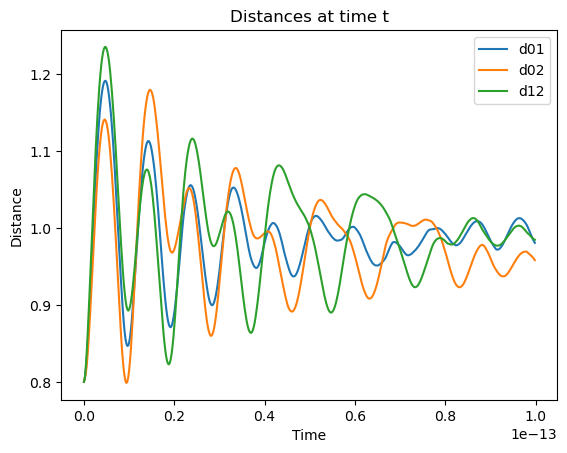

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()